In [1]:
"""
importing the necessary libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
"""
Encoding target column
"""
card = {
    'yes' : 1,
    'no' : 0
}
df.card = df.card.map(card)

In [5]:
"""
Splitting the data
"""
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.card
y_val = df_val.card
y_test = df_test.card

In [6]:
"""
Evaluating feature importance of numerical columns with auc score
"""
numerical = df.columns[df.dtypes != 'object']

num = numerical.copy()
num = num.drop('card')
for feature in num:
    auc_score = round(roc_auc_score(df_train['card'], df_train[feature]),2)
    if auc_score < 0.5:
        auc_score = round(roc_auc_score(df_train['card'], -df_train[feature]),2)
    print(feature+":", auc_score)

reports: 0.72
age: 0.52
income: 0.59
share: 0.99
expenditure: 0.99
dependents: 0.53
months: 0.53
majorcards: 0.53
active: 0.6


The feature with the highest auc score is **reports**

In [7]:
"""
creating training and validation data with selected columns 
"""
columns = ["reports", "age", "income", "share", "expenditure", 
           "dependents", "months", "majorcards", "active", "owner", "selfemp"]

train_slice_df = df_train[columns]
val_slice_df = df_val[columns]

In [8]:
"""
Training and evaluating a logistic regression  model with auc
"""
#DictVectorizer performs one hot enconding on categorical columns
dv = DictVectorizer()

#creating an instance of the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

#convert train data to dictionary
train_slice_dict = train_slice_df.to_dict(orient='records')

#one hot encoding 
X_train = dv.fit_transform(train_slice_dict)

#specifying target values
y_train = df_train['card'].values

#Training the model 
model.fit(X_train, y_train)

#convert validation data to dictionary
val_slice_dict = val_slice_df.to_dict(orient='records')

#one hot encoding 
X_val = dv.transform(val_slice_dict)

y_val = df_val['card'].values

#model predictions for the validation data
y_pred = model.predict_proba(X_val)[:,1]

#cchecking model performance with auc score
score = round(roc_auc_score(y_val, y_pred), 3)
score

0.995

In [9]:
scores = []
def find_scores(y_val, y_pred, t):
    """
    This function computes evaluated scores for a specified treshold of a model,
    and appends computed scores to a list
    params:original values, predicted values, thresholds
    returns: list t, precison, recall
    rtype:pandas dataframe
    """
    tp = ((y_pred >= t ) & (y_val == 1)).sum()
    fp = ((y_pred >= t ) & (y_val == 0)).sum()
    tn = ((y_pred < t ) & (y_val == 0)).sum()
    fn = ((y_pred < t ) & (y_val == 1)).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)     
    
    scores.append((t, tp, tn, fp, fn, p, r))            

In [10]:
"""
Evaluating precision and recall for specific thresholds,
and creating a dataframe with computed values
"""
thresholds = np.arange(0.0, 1.0, 0.01)

for t in thresholds:
     find_scores(y_val, y_pred, t)

df_scores = pd.DataFrame(scores, columns=(['t', 'tp', 'tn','fp', 'fn', 'p', 'r'])) 

(0.2, 0.4)

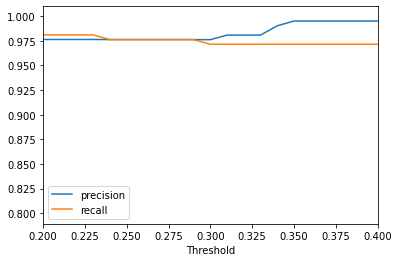

In [11]:
"""
Plotting precision and recall
"""
plt.plot(df_scores.t, df_scores.p, label='precision')
plt.plot(df_scores.t, df_scores.r, label='recall')
plt.legend()
plt.xlabel('Threshold')
plt.xlim(0.2, 0.4)

precison and recall intersect at a treshold of **0.3**

In [12]:
"""
Computing f1 score for all thresholds
"""
df_scores['f1'] = (2 * df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r'])

In [13]:
"""
Checking the treshold with the highest f1 score
"""
print(df_scores.f1.max())
df_scores[df_scores.f1==0.9832134292565947]

0.9832134292565947


,t,tp,tn,fp,fn,p,r,f1
35,0.35,205,52,1,6,0.995146,0.971564,0.983213
36,0.36,205,52,1,6,0.995146,0.971564,0.983213
37,0.37,205,52,1,6,0.995146,0.971564,0.983213
38,0.38,205,52,1,6,0.995146,0.971564,0.983213
39,0.39,205,52,1,6,0.995146,0.971564,0.983213
40,0.40,205,52,1,6,0.995146,0.971564,0.983213
41,0.41,205,52,1,6,0.995146,0.971564,0.983213


Multiple tresholds have the maximum f1 score. The answer is **0.4**

In [14]:
"""
Evaluating model using KFold
"""
from sklearn.model_selection import KFold

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
dv = DictVectorizer(sparse=False)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train.card.values
    train_dict = df_train[columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model.fit(X_train, y_train)
    
    df_val = df_full_train.iloc[val_idx]
    y_val = df_val.card.values
    val_dict = df_val[columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

#prnting the mean auc score and standard deviation for all folds
print("mean: %.3f std: %.3f" % (np.mean(scores), np.std(scores)))

mean: 0.996 std: 0.003


The standard devidation of the AUC scores is **0.003**

In [15]:
"""
Evaluating model using different tuning paramteters
"""
from sklearn.model_selection import KFold

for C in [0.01, 0.1, 1, 10]:    

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    dv = DictVectorizer(sparse=False)

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        y_train = df_train.card.values
        train_dict = df_train[columns].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        model.fit(X_train, y_train)

        df_val = df_full_train.iloc[val_idx]
        y_val = df_val.card.values
        val_dict = df_val[columns].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred = model.predict_proba(X_val)[:,1]

        score = roc_auc_score(y_val, y_pred)
        scores.append(score)

    print("%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

0.01 0.992 +- 0.006
0.1 0.995 +- 0.004
1 0.996 +- 0.003
10 0.996 +- 0.003


The C that leads to the best mean score is **1**